# Graph Comparison Script
This script aims to compare the exploration graphs with the path graphs.

Requirements: 
   * Exploration 
       * Centrality_df
       * RichClubDoc
   * Pathfinding (Single, SingleC, Dyadic)
       * Centrality_df of all paths and combined. 
       
   

## Creating the required environment (skip if already done)

Running the following cell will create a file graphs.yml that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.

In [ ]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

### Environment Creation
To create the environment, open the terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
conda env create -f graphs.yml
After running this command you have to activate the environment (Linux/MacOS: conda activate graphs, Windows: activate graphs) and then reopen the notebook in that environment.

In [4]:
import os
import cv2
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import glob
import scipy.cluster.vq as clusters
import scipy.sparse as sparse
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.special import binom as nchoosek
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib import gridspec


OG_DATA_PATH  = './'
GIT_DATA_PATH = './Results/'
GIT_GRAPH_PATH   = './Results/Graphs/'
GIT_SINGLE_PATH  = './Results/Single/'
GIT_SINGLEC_PATH = './Results/SingleC/'
GIT_DYADIC_PATH  = './Results/Dyadic/'
RESSOURCES_PATH  = './Ressources/'
GIT_PROCESSED_DATA_PATH = './Results/Comparison/'

# Getting the Folder without hidden files in ascending order 
GIT_DATA_FOLDER = sorted([f for f in os.listdir(GIT_DATA_PATH) if not f.startswith('.')], key=str.lower)
GIT_PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(GIT_PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)
GIT_GRAPH_FOLDER = sorted([f for f in os.listdir(GIT_GRAPH_PATH) if not f.startswith('.')], key=str.lower)
GIT_SINGLE_FOLDER = sorted([f for f in os.listdir(GIT_SINGLE_PATH) if not f.startswith('.')], key=str.lower)
GIT_SINGLEC_FOLDER = sorted([f for f in os.listdir(GIT_SINGLEC_PATH) if not f.startswith('.')], key=str.lower)
GIT_DYADIC_FOLDER = sorted([f for f in os.listdir(GIT_DYADIC_PATH) if not f.startswith('.')], key=str.lower)

#houselist 
house_file = RESSOURCES_PATH + 'building_collider_list.csv'
try:
    houselist = pd.read_csv(house_file)
except:
    print('HouseList could not be loaded!')
    
# global variables
path_num = 9
conditions = ['Single', 'SingleC', 'Dyadic']
directions = ['A', 'B']

    
fontsize = 20

green = [0.40,0.80,0.42]
blue = [0.27,0.38,0.99]
grey = [0.75,0.75,0.75]

# loading function for csv files 
def load_csv(path, filename):
    try: 
        with open(path + filename) as f:
            file = pd.read_csv(f)
    except:
                print("\tCould not load file - " + filename + " - !")
    return file 

In [5]:
subIDs = []
for sub in GIT_DATA_FOLDER:
    if sub[0:4].isdigit() and sub.startswith('1'):
        subIDs.append(int(sub[0:4]))
    else:
        pass
subIDs = np.unique(subIDs)
print(subIDs)

[1005 1008 1010 1011 1013 1017 1021 1023]


In [109]:
# custom subID 
subIDs = [1017]

In [3]:
# data dictionary for all the path data

data_dict = {'Single': {'A': {}, 'B': {}}, 
             'SingleC':{'A': {}, 'B': {}}, 
             'Dyadic': {'A': {'Leader': {}, 'Follower': {}}, 'B': {'Leader': {}, 'Follower': {}}}
            }


for condition in conditions:
    for direction in directions:
        for path in range(1,path_num+1):
            if condition != 'Dyadic':
                data_dict[condition][direction][str(path)] = \
                    load_csv(GIT_DATA_PATH+condition+'/Graphs/', direction+'_'+str(path)+'_centrality_df.csv')
            else:
                try: 
                    data_dict[condition][direction]['Leader'] = \
                        load_csv(GIT_DATA_PATH+condition+'/Graphs/', direction+'_'+str(path)+'_L_centrality_df.csv')
                    
                    data_dict[condition][direction]['Follower'] = \
                        load_csv(GIT_DATA_PATH+condition+'/Graphs/', direction+'_'+str(path)+'_F_centrality_df.csv')
                except:
                    pass
        
        

	Could not load file - A_1_F_centrality_df.csv - !
	Could not load file - A_2_F_centrality_df.csv - !
	Could not load file - A_3_F_centrality_df.csv - !
	Could not load file - A_4_F_centrality_df.csv - !
	Could not load file - A_5_F_centrality_df.csv - !
	Could not load file - A_6_F_centrality_df.csv - !
	Could not load file - A_7_F_centrality_df.csv - !
	Could not load file - A_8_F_centrality_df.csv - !
	Could not load file - A_9_F_centrality_df.csv - !
	Could not load file - B_3_F_centrality_df.csv - !
	Could not load file - B_4_F_centrality_df.csv - !
	Could not load file - B_5_F_centrality_df.csv - !
	Could not load file - B_6_F_centrality_df.csv - !
	Could not load file - B_7_F_centrality_df.csv - !
	Could not load file - B_8_F_centrality_df.csv - !
	Could not load file - B_9_F_centrality_df.csv - !


In [144]:
data_dict

{'Single': {'A': {'1':    Subject  Building_100  Building_101  Building_102  Building_103  \
   0     1005           NaN           NaN           NaN           1.0   
   1     1013           4.0      4.000000           NaN           NaN   
   2     1019           NaN      2.000000           NaN           2.0   
   3     1021           NaN           NaN           NaN           NaN   
   4     1022           2.0      3.000000      1.000000           3.0   
   5     1023           6.0      2.000000           NaN           NaN   
   6     1055           2.0      6.000000      2.000000           4.0   
   7     1056           3.0      2.000000      3.000000           1.0   
   8     1069           3.0           NaN      2.000000           2.0   
   9     1074           4.0      3.000000           NaN           2.0   
   10    1075           1.0      2.000000           NaN           1.0   
   11    1079           2.0      2.000000      2.000000           2.0   
   12    Mean           3.0    

In [110]:
# ------ PREPARATION ------

correlations_all = {'Single': {'A': {}, 'B': {}}, 
                    'SingleC':{'A': {}, 'B': {}}, 
                    'Dyadic': {'A': {'Leader': {}, 'Follower': {}}, 'B': {'Leader': {}, 'Follower': {}}}
                    }

for condition in conditions:
    for direction in directions:
        for path in range(1, path_num+1):
            if condition == 'Dyadic':
                correlations_all[condition][direction]['Leader'][str(path)] = []
                correlations_all[condition][direction]['Follower'][str(path)] = []
            else:
                correlations_all[condition][direction][str(path)] = []
            
                


# ------ LOADING ------

# exploration
# open the exploration centrality csv file as dictionary
centrality_df = load_csv(GIT_GRAPH_PATH, 'centrality_df.csv')
            
# pathfinding 
# open the pathfinding condition csv files
single_info = load_csv(GIT_SINGLE_PATH, 'Single_Performance_Analysis.csv')
singleC_info = load_csv(GIT_SINGLEC_PATH, 'SingleC_Performance_Analysis.csv')
dyadic_info = load_csv(GIT_DYADIC_PATH, 'Dyadic_Performance_Analysis.csv')

all_paths_A_centrality_df = load_csv(GIT_SINGLE_PATH+'Graphs/', 'A_all_centrality_df.csv')
all_paths_B_centrality_df = load_csv(GIT_SINGLE_PATH+'Graphs/', 'B_all_centrality_df.csv')
          
# Load later in the loop

            
# three for loops
# 1. for the condition (A or B)
    # 2. for the path
# 3. for the subject

for sub in subIDs:
    
    # the degree data of the subject
    centrality_data = centrality_df[centrality_df.Subject == str(sub)].copy()
        
    for path in range(1, path_num+1):

    # find out in which condition the subject was 

        # If Single 
        if sub in list(single_info.SubjectID):
            # set the condition 
            condition = conditions[0]
            
            # check for direction
            direction = single_info[single_info.SubjectID == sub].Condition.values[0]
            
            path_data = data_dict[condition][direction][str(path)]
            path_data = path_data[path_data.Subject == sub]
            # filter out the subject row
            path_data = data_dict[condition][direction][str(path)]
            path_data = path_data[path_data.Subject == str(sub)]
            # drop nan values as well as Subject Mean and STD column
            path_data = path_data.dropna(axis=1)
            path_data = path_data.drop(['Subject', 'Mean', 'STD'], axis=1)
            path_data = path_data.reset_index(drop=True)
            
            centrality_pathhouses = centrality_data[path_data.columns].copy()
            centrality_pathhouses = centrality_pathhouses.reset_index(drop=True)
            
            correlations_all[condition][direction][str(path)].append(
                centrality_pathhouses.corrwith(path_data, axis=1).values[0])

        elif sub in list(singleC_info.SubjectID):
            # set the condition 
            condition = conditions[1]
            
            # check for direction
            direction = singleC_info[singleC_info.SubjectID == sub].Condition.values[0]

            path_data = data_dict[condition][direction][str(path)]
            path_data = path_data[path_data.Subject == sub]
            # filter out the subject row
            path_data = data_dict[condition][direction][str(path)]
            path_data = path_data[path_data.Subject == str(sub)]
            # drop nan values as well as Subject Mean and STD column
            path_data = path_data.dropna(axis=1)
            path_data = path_data.drop(['Subject', 'Mean', 'STD'], axis=1)
            path_data = path_data.reset_index(drop=True)
            
            centrality_pathhouses = centrality_data[path_data.columns].copy()
            centrality_pathhouses = centrality_pathhouses.reset_index(drop=True)
            
            correlations_all[condition][direction][str(path)].append(
                centrality_pathhouses.corrwith(path_data, axis=1).values[0])
            
        elif sub in list(dyadic_info.SubjectID):
            # set the condition 
            condition = conditions[2]
            
            # check for direction
            direction = dyadic_info[dyadic_info.SubjectID == sub].Condition.values[0] 

            if dyadic_info[dyadic_info.SubjectID == sub]['Leader?'] == True:
                role = 'Leader'
            else:
                role = 'Follower'
                
            path_data = data_dict[condition][direction][role][str(path)]
            path_data = path_data[path_data.Subject == sub]
            # filter out the subject row
            path_data = data_dict[condition][direction][role][str(path)]
            path_data = path_data[path_data.Subject == str(sub)]
            # drop nan values as well as Subject Mean and STD column
            path_data = path_data.dropna(axis=1)
            path_data = path_data.reset_index(drop=True)
            path_data = path_data.drop(['Subject', 'Mean', 'STD'], axis=1)
            
            centrality_pathhouses = centrality_data[path_data.columns].copy()
            centrality_pathhouses = centrality_pathhouses.reset_index(drop=True)
            
            correlations_all[condition][direction][str(path)].append(
                centrality_pathhouses.corrwith(path_data, axis=1).values[0])

        else:
            print('Subject ' + str(sub) + ' is not in any condition!')


In [125]:
data_1023 = all_paths_A_centrality_df[all_paths_B_centrality_df.Subject == '1017']

data_1023 = data_1023.dropna(axis=1)
data_1023 = data_1023.reset_index(drop=True)
data_1023 = data_1023.drop(['Subject', 'Mean', 'STD'], axis=1)

centrality_1023 = centrality_data[data_1023.columns].copy()
centrality_1023 = centrality_1023.reset_index(drop=True)

data_1023.corrwith(centrality_1023, axis=1)



/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0    0.669099
dtype: float64

<AxesSubplot:>

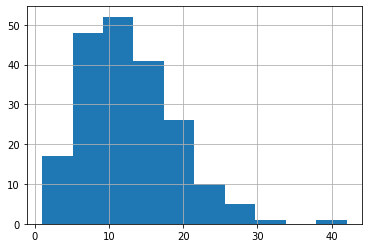

In [126]:
centrality_1023.loc[0].hist()

<AxesSubplot:>

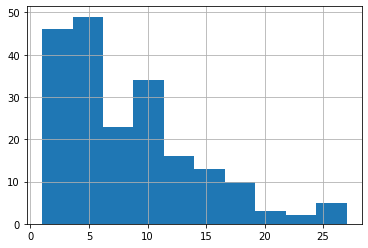

In [127]:
data_1023.loc[0].hist()

In [108]:
single_info

,SubjectID,Condition,Dyadic?,Leader?,SessionID,P1:Success,P1:TimeSec,P1:Time After Guide,P1:Distance Covered,P1:Dist After Fail,...,P8:TimeSec,P8:Time After Guide,P8:Distance Covered,P8:Dist After Fail,P9:Success,P9:TimeSec,P9:Time After Guide,P9:Distance Covered,P9:Dist After Fail,#Success
0,1004,B,False,False,NaN,False,449.037666,117.037666,1755.037910,478.159893,...,390.436826,85.436826,1770.585236,409.925404,True,113.507971,-186.492029,496.366978,0.000000,3
1,1005,A,False,False,NaN,True,158.458649,-141.541351,470.272979,0.000000,...,182.991541,-200.008459,713.965772,0.000000,False,485.039520,153.039520,1822.081722,721.341452,6
2,1008,B,False,False,NaN,True,89.310862,-242.689138,442.416783,0.000000,...,90.587071,-214.412929,445.694201,0.000000,True,106.655506,-193.344494,529.413491,0.000000,8
3,1010,B,False,False,NaN,False,602.111310,270.111310,1660.381992,48.622561,...,162.011336,-142.988664,766.886526,0.000000,True,196.642525,-103.357475,935.244486,0.000000,7
4,1011,B,False,False,NaN,True,102.925068,-229.074932,474.958253,0.000000,...,368.540978,63.540978,1647.211780,315.342526,True,217.615655,-82.384345,980.786808,0.000000,7
5,1013,A,False,False,NaN,True,125.361833,-174.638167,561.437040,0.000000,...,136.801561,-246.198439,638.763385,0.000000,False,438.497586,106.497586,1847.357822,497.463189,8
6,1017,B,False,False,NaN,True,261.689323,-70.310677,1154.835160,0.000000,...,432.588424,127.588424,1944.986397,557.092471,True,289.393871,-10.606129,1384.185154,0.000000,4
7,1018,B,False,False,NaN,True,165.254440,-166.745560,749.457232,0.000000,...,407.066795,102.066795,1995.233412,510.776900,True,273.094684,-26.905316,1320.094456,0.000000,7
8,1019,A,False,False,NaN,True,100.749390,-199.250610,484.189099,0.000000,...,114.624974,-268.375026,564.016549,0.000000,False,470.427692,138.427692,2318.707260,692.952190,7
9,1021,A,False,False,NaN,False,398.568231,98.568231,1851.263347,486.417396,...,118.187025,-264.812975,571.066503,0.000000,False,447.441651,115.441651,2196.429637,567.590842,6


In [116]:
# calculate the mean path correlation of degree distributions
mean_corr_df = pd.DataFrame()

for condition in conditions:
    for direction in directions:
        for path in range(1, path_num+1):
            if condition != 'Dyadic':
                mean_corr_df.loc[0, condition + '-' + direction + '-' + str(path)] = np.mean(correlations_all[condition][direction][str(path)])
            else:
                mean_corr_df.loc[0, condition + '-' + direction + '-' + str(path) + ' - Leader'] = \
                    np.mean(correlations_all[condition][direction]['Leader'][str(path)])
                mean_corr_df.loc[0, condition + '-' + direction + '-' + str(path) + ' - Follower'] = \
                    np.mean(correlations_all[condition][direction]['Follower'][str(path)])
                
                

/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [119]:
mean_corr_df.T[:60]

,0
Single-A-1,NaN
Single-A-2,NaN
Single-A-3,NaN
Single-A-4,NaN
Single-A-5,NaN
Single-A-6,NaN
Single-A-7,NaN
Single-A-8,NaN
Single-A-9,NaN
Single-B-1,0.252878


In [90]:
centrality_pathhouses

,Building_137,Building_142,Building_211,Building_214,Building_215,Building_216,Building_218,Building_219,Building_220,Building_221,Building_223,Building_224,Building_229,Building_233,Building_236,TaskBuilding_36,TaskBuilding_44,TaskBuilding_45,TaskBuilding_48
0,23.0,24.0,27.0,22.0,16.0,10.0,5.0,9.0,18.0,2.0,7.0,7.0,22.0,13.0,23.0,17.0,21.0,15.0,17.0


<AxesSubplot:>

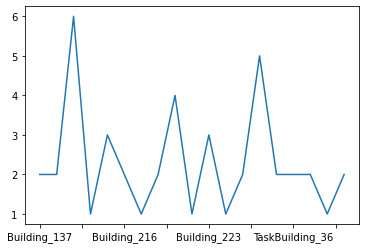

In [82]:
path_data.loc[0].plot()

<AxesSubplot:>

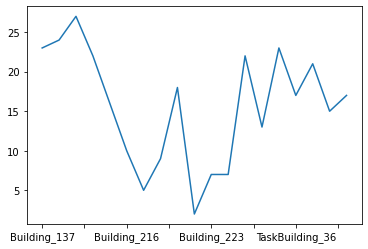

In [83]:
centrality_pathhouses.loc[0].plot()